In [1]:
import os
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from skimage.feature import hog
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
%matplotlib inline

## Feature Extraction(HOG + color histogram + spatial)

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
    
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features


# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    

## Sliding window And Drawing boxes functions

In [3]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


## Extract features from a single image window

In [4]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


## Function to search list of windows

In [5]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

## Read dataset

In [6]:
cars = []
notcars = []

images_non_vehicles = glob.glob('../non-vehicles/GTI/image*.png')
images_non_vehicles2 = glob.glob('../non-vehicles/Extras/extra*.png')

images_vehicles = glob.glob('../vehicles/GTI_Far/image*.png')
images_vehicles2 = glob.glob('../vehicles/GTI_Left/image*.png')
images_vehicles3 = glob.glob('../vehicles/GTI_MiddleClose/image*.png')
images_vehicles4 = glob.glob('../vehicles/GTI_Right/image*.png')
images_vehicles5 = glob.glob('../vehicles/KITTI_extracted/*.png')

#not car
for image in images_non_vehicles:
    notcars.append(image)

for image in images_non_vehicles2:
    notcars.append(image)
    
#car
for image in images_vehicles:
    cars.append(image)
    
for image in images_vehicles2:
    cars.append(image)
    
for image in images_vehicles3:
    cars.append(image)
    
for image in images_vehicles4:
    cars.append(image)
    
for image in images_vehicles5:
    cars.append(image)

In [7]:
len(cars)

8792

In [8]:
len(notcars)

8968

## Extract features from dataset

In [9]:
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 8700
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 700] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

## Normalize + Split + Train Dataset + Measure accuracy on test set

In [10]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
104.4 Seconds to train SVC...
Test Accuracy of SVC =  0.9922


## Heat function + thresholding heatmap function +funtion to draw boxes from labeled heatmap

In [11]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
        text_put='Car '+ str(car_number)
        cv2.putText(img,text_put,(np.min(nonzerox)+30, np.min(nonzeroy)- 20), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),3)
        center_x=(np.min(nonzerox)+np.max(nonzerox))/2
        center_y=(np.min(nonzeroy)+np.min(nonzeroy))/2
        text_put='x= '+ str(int(center_x))
        cv2.putText(img,text_put,(np.min(nonzerox)+30, np.max(nonzeroy)+ 30), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),3)
        text_put="y= "+str(int(center_y))
        cv2.putText(img,text_put,(np.min(nonzerox)+30, np.max(nonzeroy)+ 60), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),3)
        
    # Return the image
    text_put='Number of cars - '+ str(labels[1])
    cv2.putText(img,text_put,(250,100), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,255,255),4)
    return img

## Search window + Vehicle detection Pipeline

In [55]:

image=mpimg.imread("test6.jpg")

y_start_stop1 = [400, 520]#60,60
y_start_stop2 = [380, 550]#90,90
y_start_stop2 = [380, 550]#90,90
y_start_stop3 = [360, 600]#110,110
y_start_stop4 = [340, 700]#150
y_start_stop5 = [320, 700]#150


window1 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop1, 
                    xy_window=(90, 90), xy_overlap=(0.8, 0.5))
window12 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop1, 
                    xy_window=(80, 80), xy_overlap=(0.5, 0.5))    
window2 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop2, 
                    xy_window=(140, 140), xy_overlap=(0.7, 0.5))
window22 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop2, 
                    xy_window=(160, 160), xy_overlap=(0.7, 0.5))
window3 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop3, 
                    xy_window=(170, 170), xy_overlap=(0.8, 0.5))
window4 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop4, 
                    xy_window=(250,250), xy_overlap=(0.5, 0.5))
window5 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop5, 
                    xy_window=(320,320), xy_overlap=(0.5, 0.5))
windows=window1+window12+window2+window3+window4+window5+window22

def vehicle_detection(img):
    image=cv2.resize(img,(1280, 720), interpolation = cv2.INTER_LINEAR)
    draw_image = np.copy(image)
    final_image=np.copy(image)
    image = image.astype(np.float32)/255
    
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)  

    final_hot_window=hot_windows
    window_img = draw_boxes(draw_image, final_hot_window, color=(0, 255, 0), thick=6)
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap=add_heat(heatmap,final_hot_window)
    heatmap=apply_threshold(heatmap,2)
    labels = label(heatmap)
    final_image=draw_labeled_bboxes(final_image,labels)
    
    return final_image

def vehicle_detection_test(img):
    image=cv2.resize(img,(1280, 720), interpolation = cv2.INTER_LINEAR)
    draw_image = np.copy(image)
    final_image=np.copy(image)
    image = image.astype(np.float32)/255
    
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)  

    final_hot_window=hot_windows
    window_img = draw_boxes(draw_image, final_hot_window, color=(0, 255, 0), thick=6)
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap=add_heat(heatmap,final_hot_window)
    heatmap_return=np.copy(heatmap)
    heatmap=apply_threshold(heatmap,1)
    labels = label(heatmap)
    final_image=draw_labeled_bboxes(final_image,labels)
    
    return final_image, window_img, heatmap_return, heatmap

## Run pipeline on test images and save them

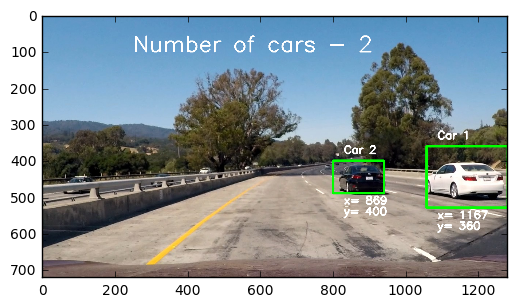

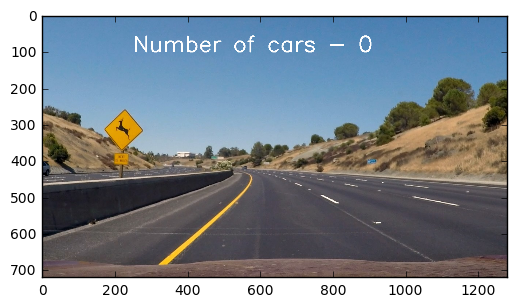

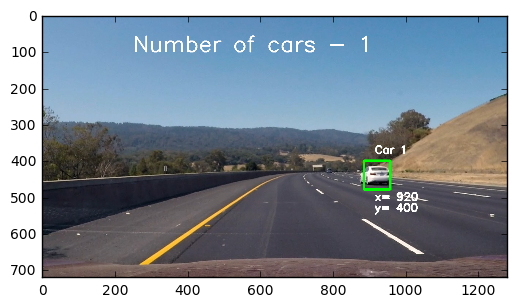

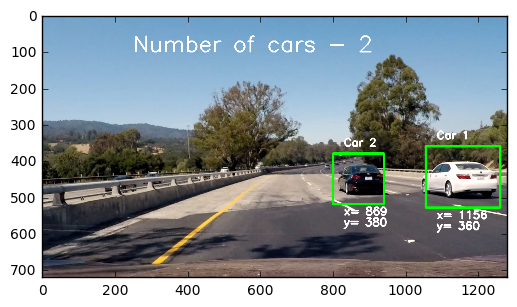

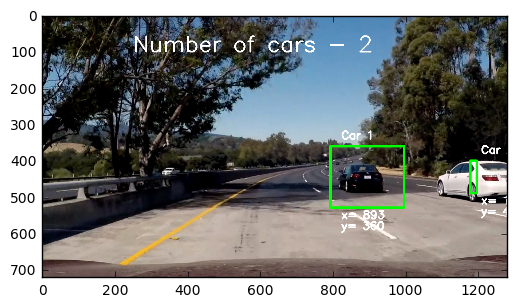

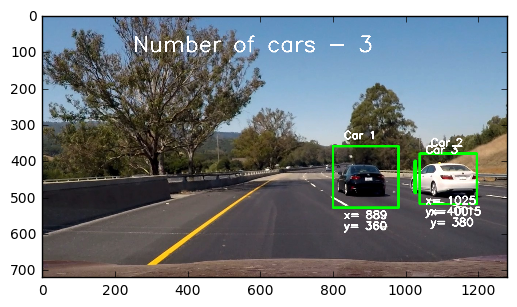

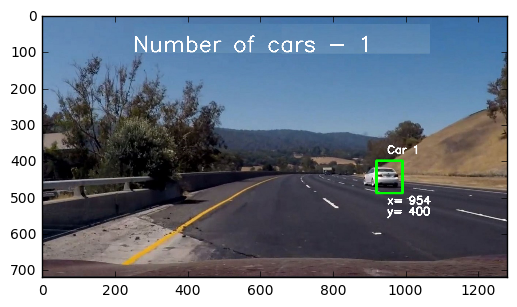

In [50]:
i=0
test_images = glob.glob('test*.jpg')

for img in test_images:
    image=mpimg.imread(img)
    final_image=np.copy(image)
    final_image=vehicle_detection(image)
    cv2.imwrite("output_images/"+img,final_image)
    plt.figure(i)
    plt.imshow(final_image)
    i=i+1;
    
i=0

## Pipeline Result on project video

In [57]:
detection_output = 'vehicle.mp4'
clip1 = VideoFileClip("project_video.mp4")
vehicle_clip = clip1.fl_image(vehicle_detection) #NOTE: this function expects color images!!
%time vehicle_clip.write_videofile(detection_output, audio=False)

[MoviePy] >>>> Building video vehicle_detected_project_video2_v5.mp4
[MoviePy] Writing video vehicle_detected_project_video2_v5.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [37:17<00:02,  2.06s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: vehicle_detected_project_video2_v5.mp4 

Wall time: 37min 18s


## Pipeline Result on test video

In [ ]:
detection_output = 'output_test_video.mp4'
clip2 = VideoFileClip("test_video.mp4")
vehicle_clip = clip2.fl_image(vehicle_detection) #NOTE: this function expects color images!!
%time vehicle_clip.write_videofile(detection_output, audio=False)

## Hog Features on car image

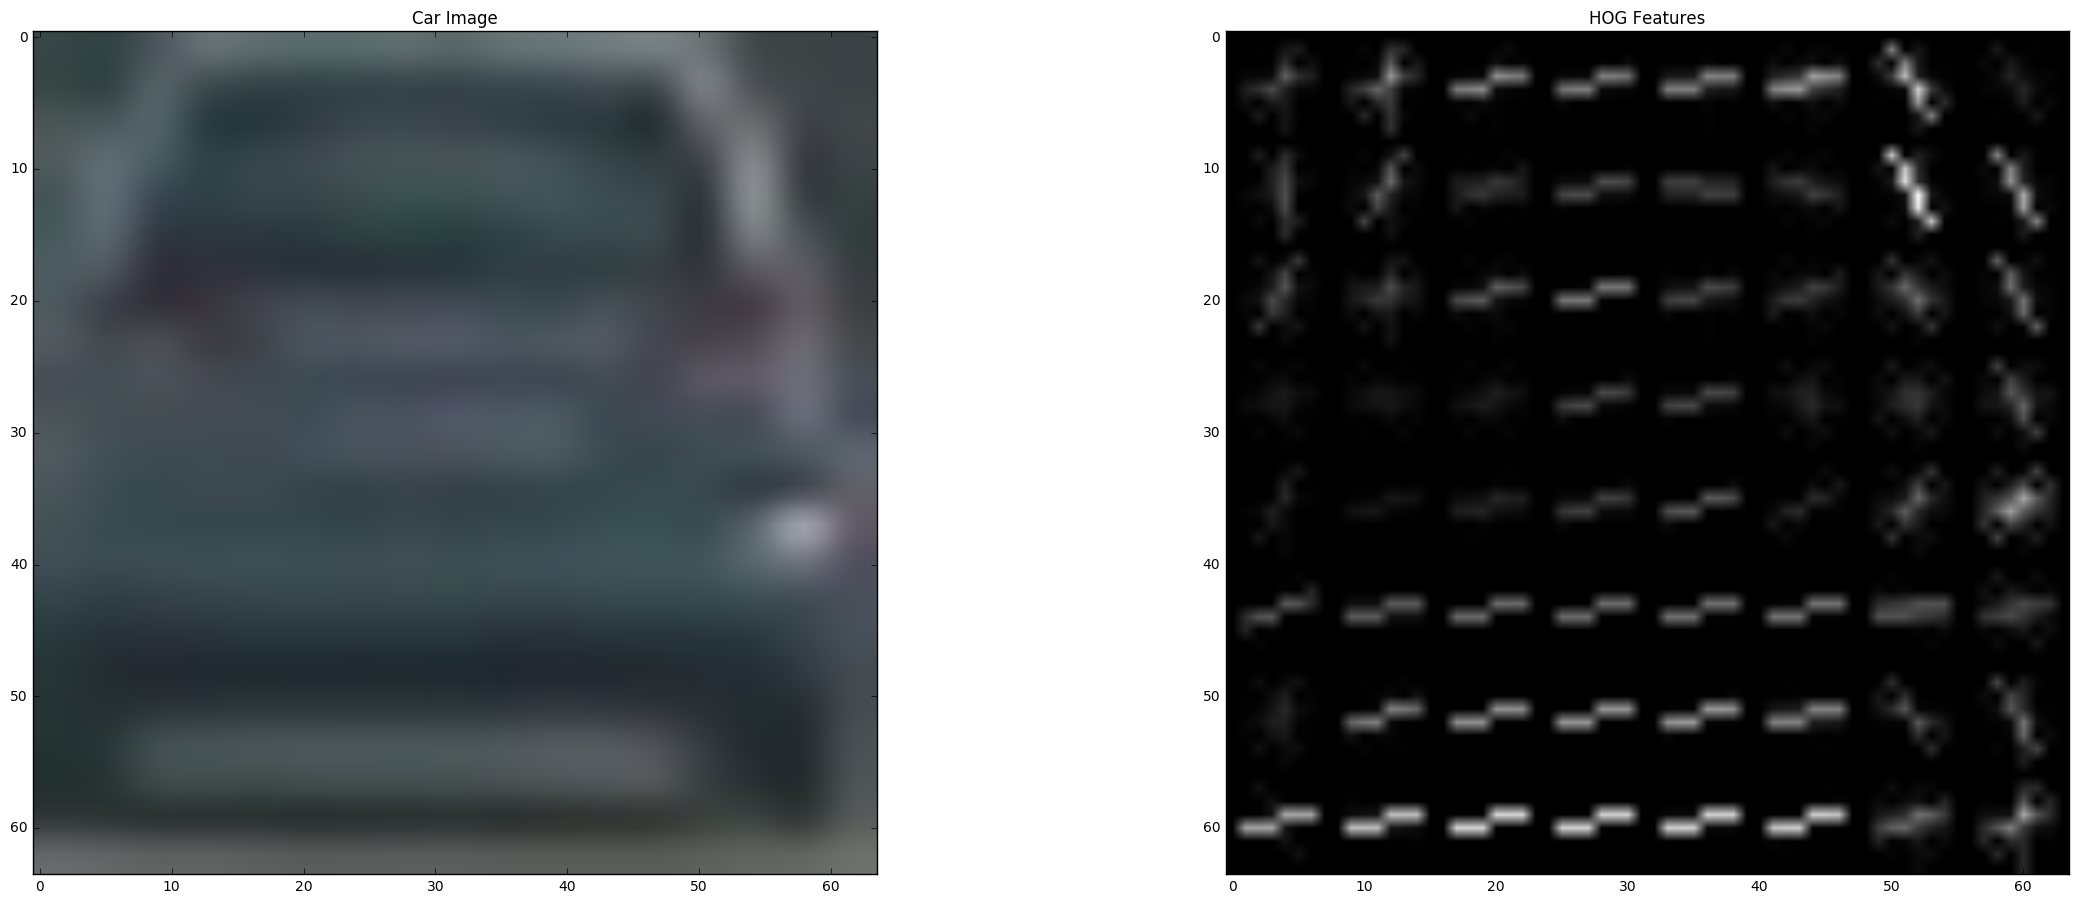

In [60]:
a=mpimg.imread(cars[10])
feature_image = cv2.cvtColor(a, cv2.COLOR_RGB2YCrCb)
features,visualization=get_hog_features(feature_image[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(a)
ax1.set_title('Car Image')
ax2.imshow(visualization,cmap='gray')
ax2.set_title('HOG Features')

## Stepwise Pipeline Result on Images

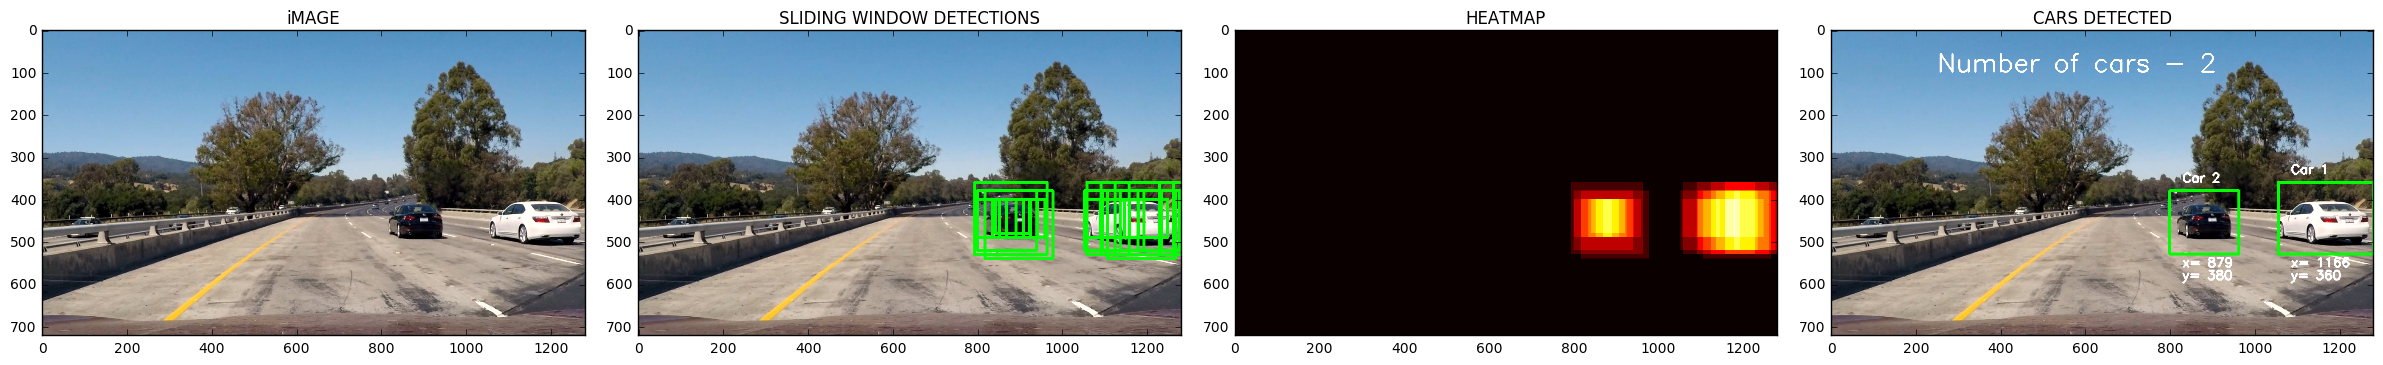

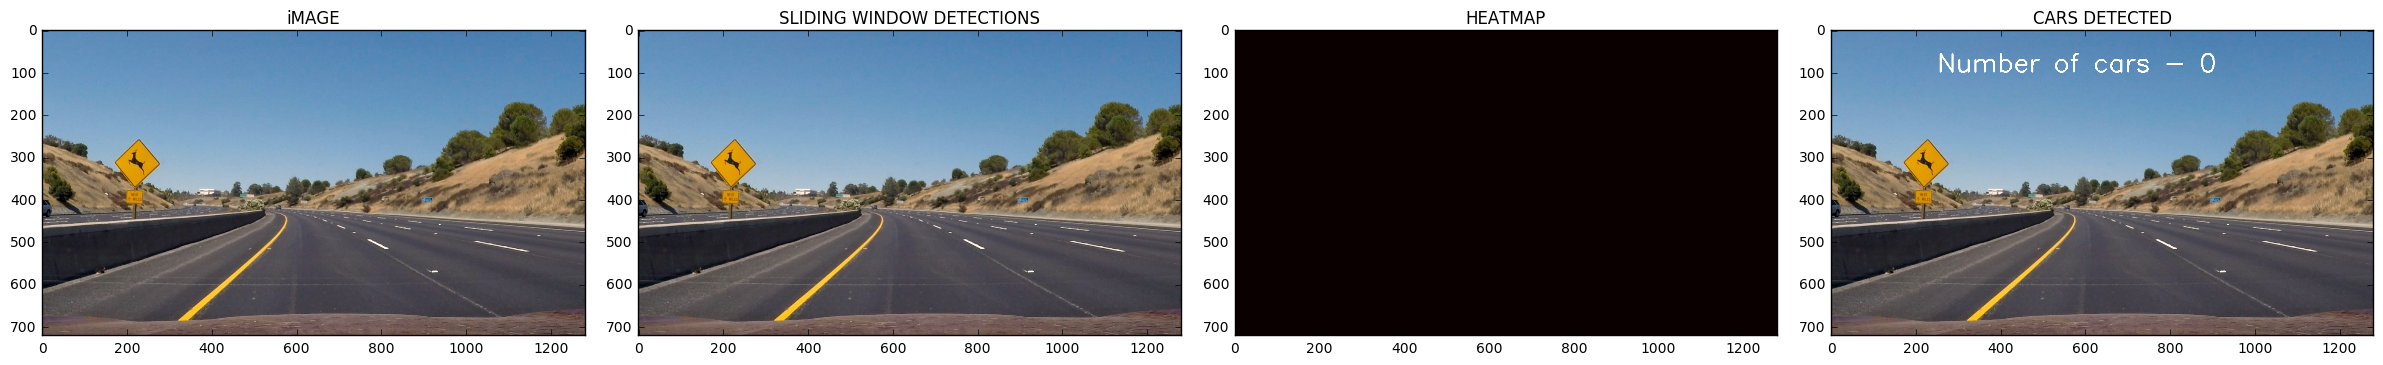

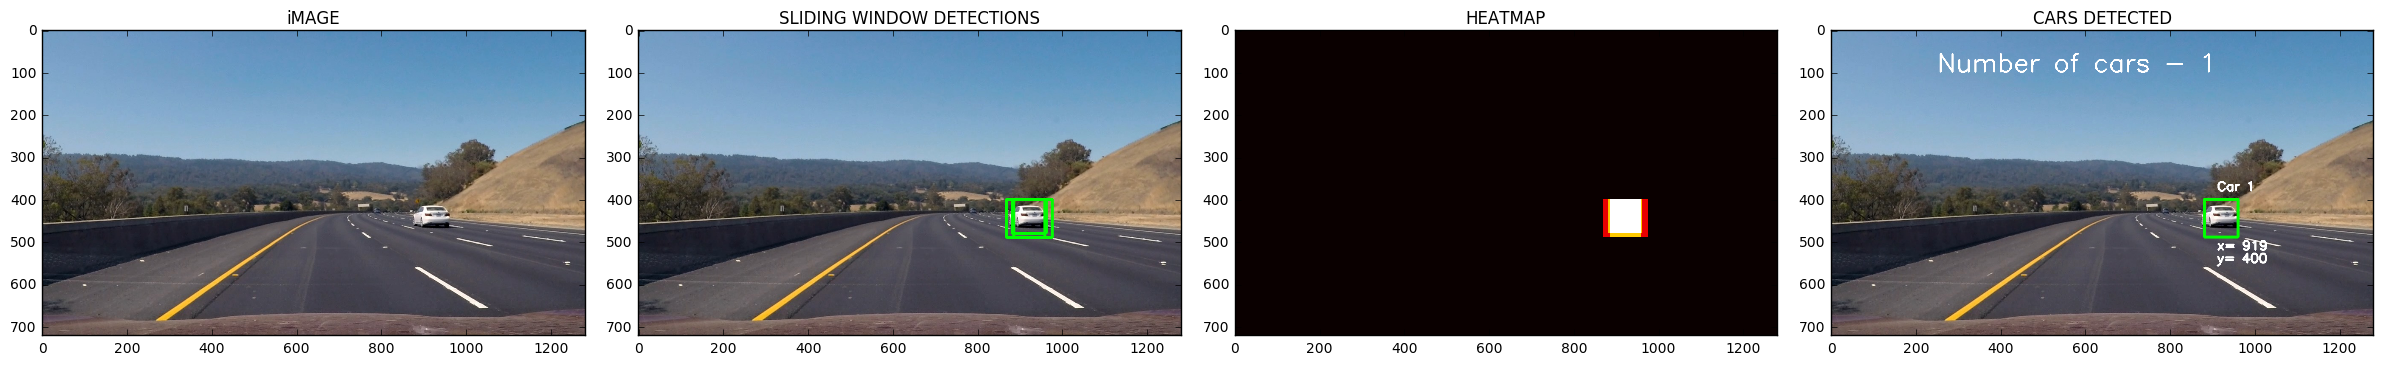

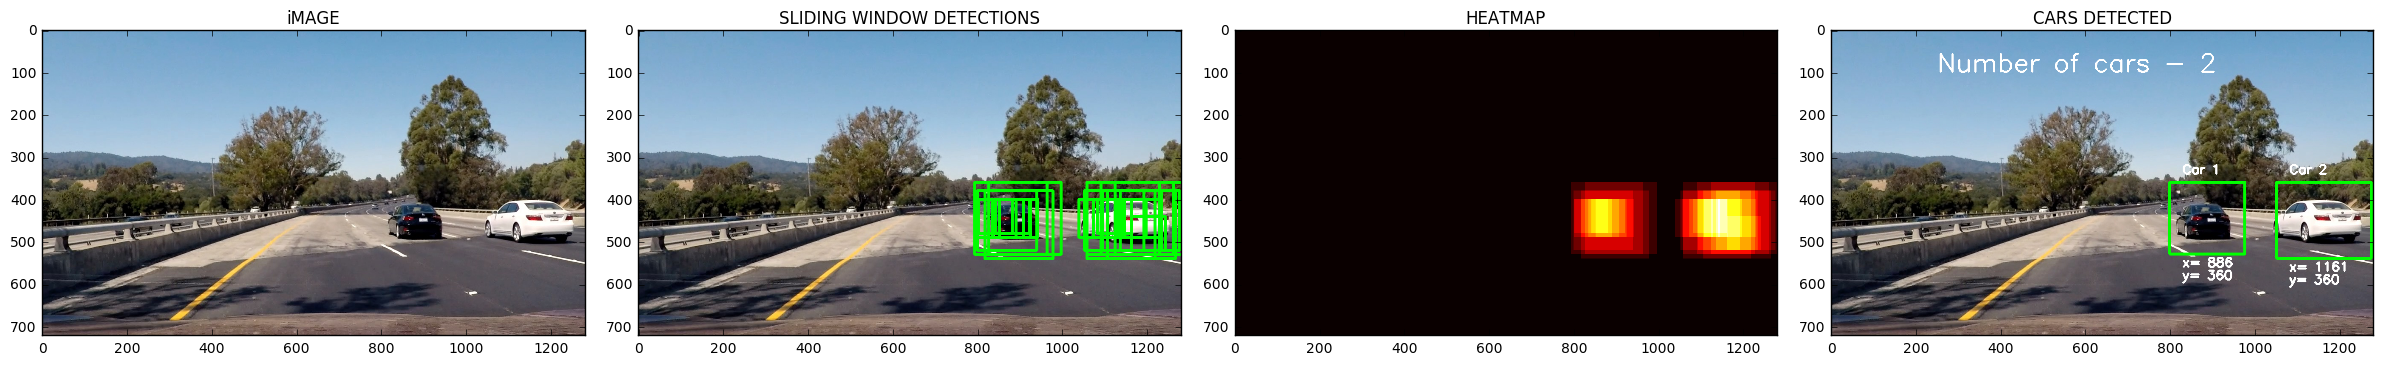

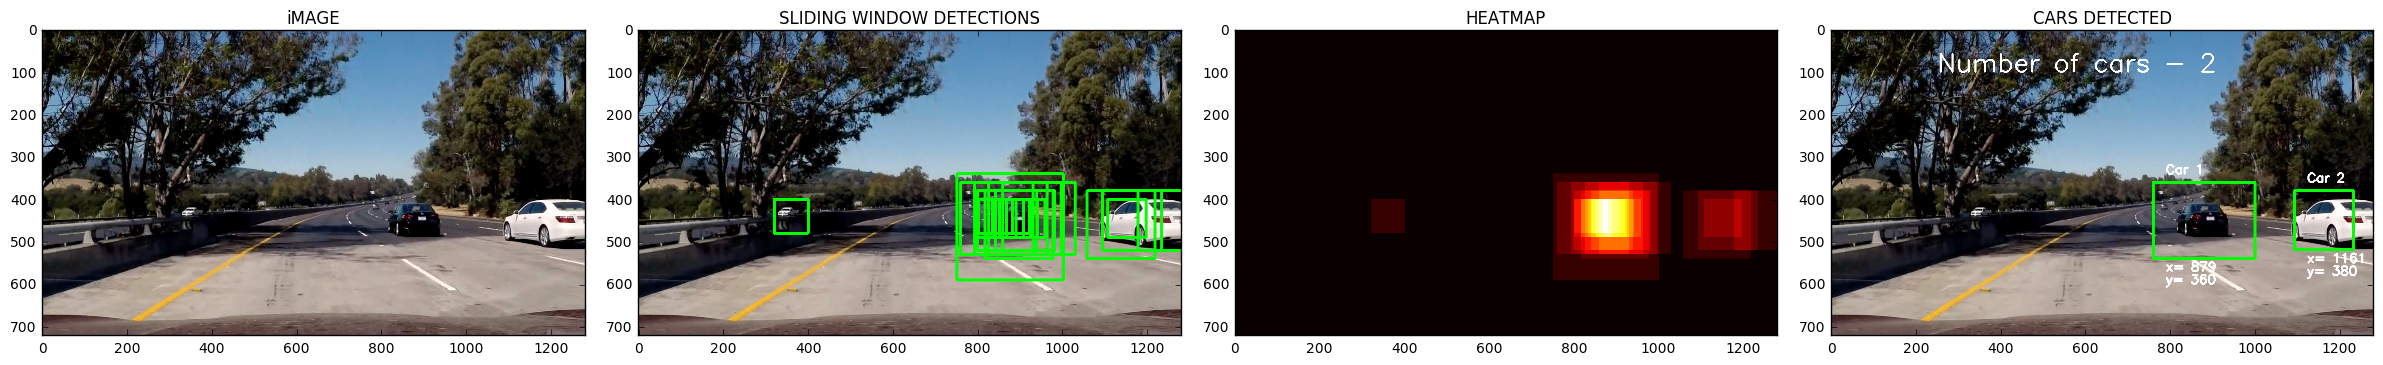

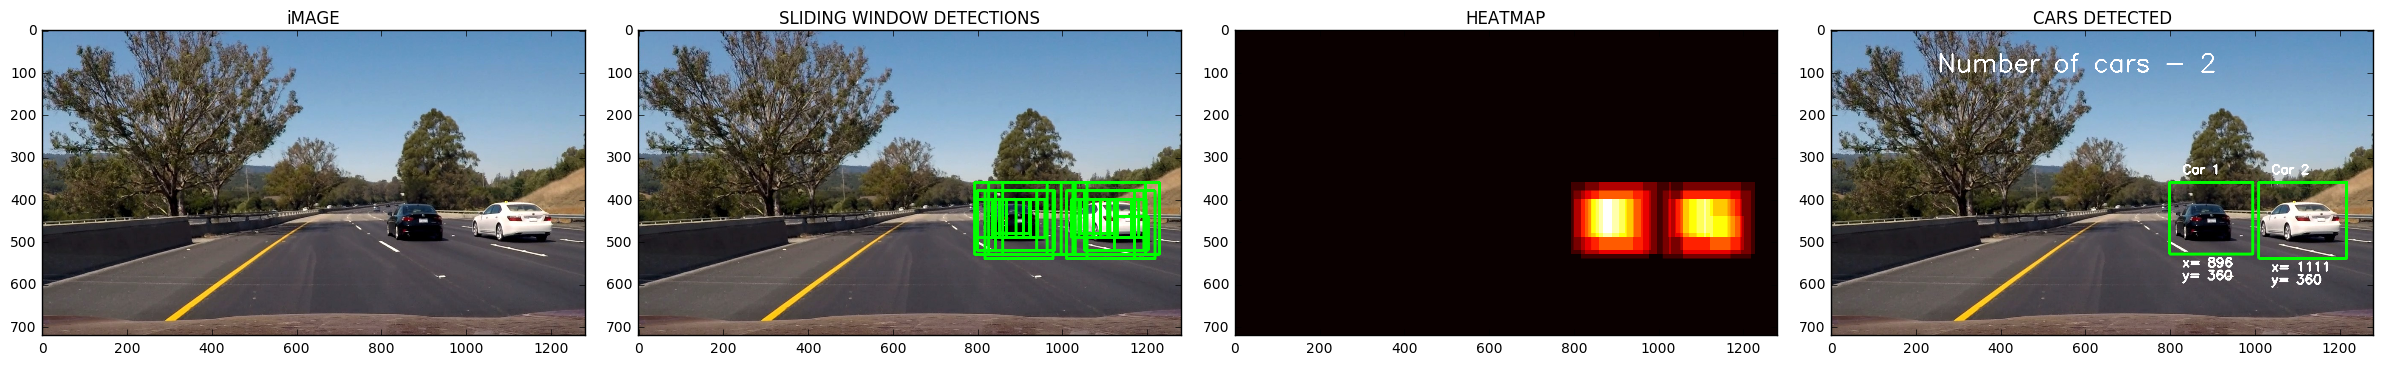

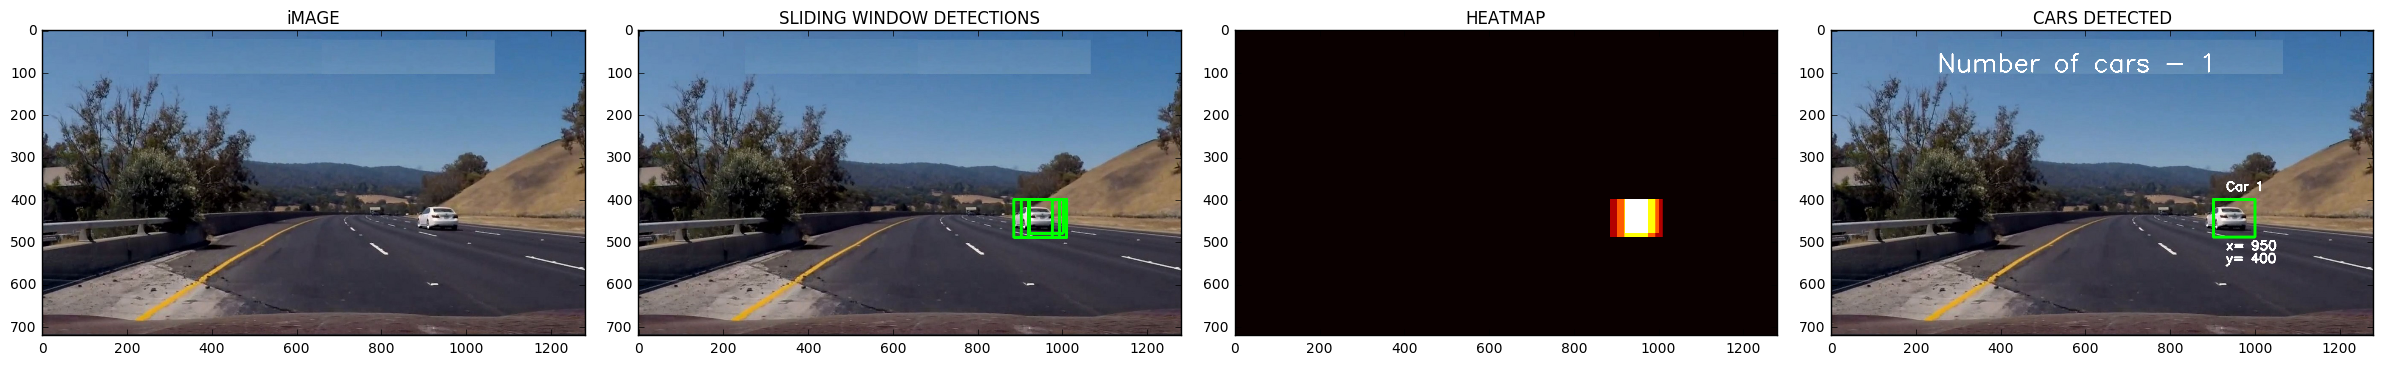

In [56]:
i=0
test_images = glob.glob('test*.jpg')

for img in test_images:
    image=mpimg.imread(img)
    final_image=np.copy(image)
    a,b,c,d=vehicle_detection_test(image)
    plt.figure(i)
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('iMAGE')
    ax2.imshow(b)
    ax2.set_title('SLIDING WINDOW DETECTIONS')
    ax3.imshow(c,cmap='hot')
    ax3.set_title('HEATMAP')
    ax4.imshow(a)
    ax4.set_title('CARS DETECTED')
    i=i+1;
    
i=0